In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
MAIN_DIR = "cafa-5-protein-function-prediction/"

In [3]:
class config:
    train_seq_path = MAIN_DIR + "Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "Train/train_terms.tsv"
    test_seq_path = MAIN_DIR + "Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 5
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "EMS2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "EMS2" : 1280
}

In [5]:
from torch.utils.data import Dataset

class ProteinSequenceDataset(Dataset): 
    def __init__(self, datatype, embeddings_source):   
        # 'datatype' specifies whether it's for training or testing data and
        # 'embeddings_source' specifies the source of the protein sequence
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        # load the protein sequence embeddings and their corresponding IDs
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load(embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
        
        if embeddings_source == "T5":
            embeds = np.load(embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        # create a Pandas DataFrame
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        # load labels
        if datatype=="train":
            np_labels = np.load(
                "train-targets-top"+str(config.num_labels)+ \
                "/train_targets_top"+str(config.num_labels)+".npy")
            df_labels = pd.DataFrame(self.df['EntryID'])
            df_labels['labels_vect']=[row for row in np_labels]
            self.df = self.df.merge(df_labels, on="EntryID")
     
    # the length of the dataset
    def __len__(self):
        return len(self.df)
    
    # retrieve a sample from the dataset at a given index
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id
        

## Model Architecture Buillding and Training

We want to define a PyTorch neural network model class named MultiLayerPerceptron. This class represents a multi-layer perceptron (MLP) model with three hidden layers.

In [6]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):  
        # 'input_dim' defines dimensionality of the input features and
        # 'num_classes' number of output classes or units
        
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 864)
        self.activation1 = torch.nn.ReLU() 
        self.linear2 = torch.nn.Linear(864, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)
      

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

We define `CNN1D` class for processing sequential data, such as protein sequence embeddings.
This class defines a PyTorch neural network, representing a 1D Convolutional Neural Network (CNN). 

In [7]:
class CNN1D(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
    # # 'input_dim' defines dimensionality of the input features and
    # 'num_classes' number of output classes or units  
    
        super(CNN1D, self).__init__()
        # First Convolutional Layer
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Second Convolutional Layer
        self.conv2 = torch.nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        # First Fully Connected Layer
        self.fc1 = torch.nn.Linear(in_features=int(8 * input_dim/4), out_features=864)
        # Second Fully Connected Layer (Output Layer)
        self.fc2 = torch.nn.Linear(in_features=864, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(torch.nn.functional.tanh(self.conv1(x)))
        x = self.pool2(torch.nn.functional.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    # Load the training dataset
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    
    # Split the training dataset into train and validation sets
    train_set, val_set = torch.utils.data.random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    
    # Create dataloaders for training and validation
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    # Initialize the model based on the specified model_type
    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    # Set up optimizer, scheduler, loss function, and metrics
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    # Initialize lists to store loss and score history
    train_loss_history=[]
    val_loss_history=[]
    train_f1score_history=[]
    val_f1score_history=[]
    
    print("BEGIN TRAINING...")
    # Loop through epochs
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        # Iterate through batches in the training dataset
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        # Iterate through batches in the validation dataset
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        # Adjust the learning rate using the scheduler based on validation loss
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [9]:
ems2_model, ems2_losses, ems2_scores = train_model(embeddings_source="EMS2",model_type="convolutional")

BEGIN TRAINING...
EPOCH  1


100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:54<00:00,  8.71it/s]


Running Average TRAIN Loss :  141.58360551191973
Running Average TRAIN F1-Score :  0.0565419194291343
Running Average VAL Loss :  142.55853864124842
Running Average VAL F1-Score :  0.055686246237850616


EPOCH  2


100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [02:02<00:00,  8.19it/s]


Running Average TRAIN Loss :  141.38187768957118
Running Average TRAIN F1-Score :  0.05590799885553556
Running Average VAL Loss :  142.1207778794425
Running Average VAL F1-Score :  0.05603062298281917


EPOCH  3


100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:54<00:00,  8.73it/s]


Running Average TRAIN Loss :  141.35389107352609
Running Average TRAIN F1-Score :  0.05621520431338252
Running Average VAL Loss :  142.13436208452498
Running Average VAL F1-Score :  0.05612267151341906


EPOCH  4


100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:55<00:00,  8.67it/s]


Running Average TRAIN Loss :  141.31480967152964
Running Average TRAIN F1-Score :  0.05663389831662297
Running Average VAL Loss :  142.18693392617362
Running Average VAL F1-Score :  0.05698908393138221


EPOCH  5


100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:56<00:00,  8.62it/s]


Running Average TRAIN Loss :  141.19428138085058
Running Average TRAIN F1-Score :  0.057071269879659096
Running Average VAL Loss :  142.39871610913957
Running Average VAL F1-Score :  0.057275642308273485


TRAINING FINISHED
FINAL TRAINING SCORE :  0.057071269879659096
FINAL VALIDATION SCORE :  0.057275642308273485


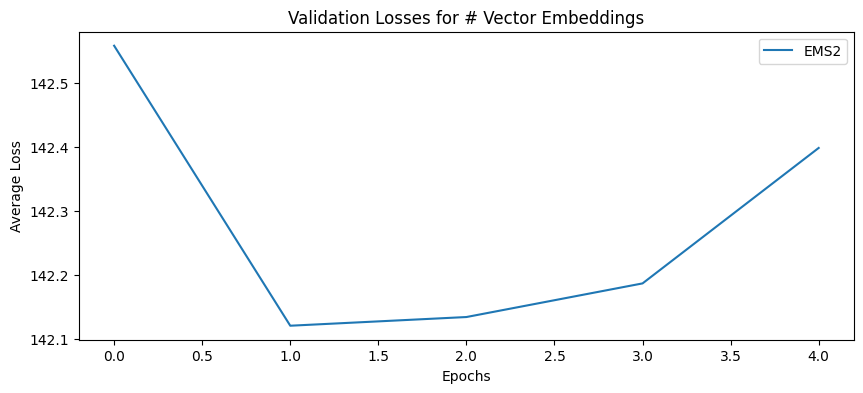

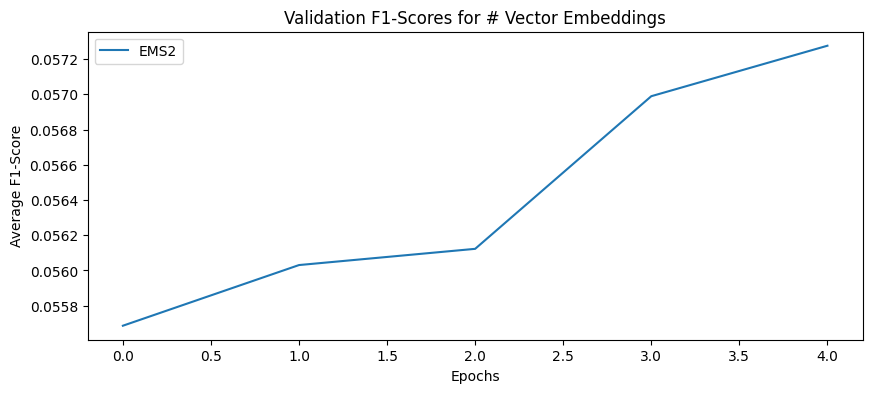

In [10]:
plt.figure(figsize = (10, 4))
#plt.plot(ems2_losses["val"], label = "EMS2")
#plt.plot(t5_losses["val"], label = "T5")
plt.plot(ems2_losses["val"], label = "EMS2") 
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
#plt.plot(ems2_scores["val"], label = "EMS2")
#plt.plot(t5_scores["val"], label = "T5")
plt.plot(ems2_scores["val"], label = "EMS2")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [11]:
def predict(embeddings_source):
    
    # Load the test dataset
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Determine which trained model to use based on embeddings_source
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = ems2_model
    
    # Set the model to evaluation mode
    model.eval()
    
    # Load and preprocess labels data
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    # Initialize arrays to store prediction results
    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    # Iterate through test data and make predictions
    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        # Get sigmoid probabilities from the model's output
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    # Create a DataFrame to store the prediction results
    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    
    return submission_df

In [12]:
submission_df = predict("EMS2")

GENERATE PREDICTION FOR TEST SET...


141864it [04:07, 572.41it/s]


PREDICTIONS DONE


In [13]:
len(submission_df)

70932000

## Submission

In [14]:
#this submission was obtained by training models on BlastP, Sprof, QuickGo and DeeepGoZero offline
submission2 = pd.read_csv('blast-quick-sprof-zero-pred/submission.tsv',
    sep='\t', header=None, names=['Id2', 'GO term2', 'Confidence2']) 

In [15]:
submission2

,Id2,GO term2,Confidence2
0,Q3UPK1,GO:0005634,1.000
1,Q3UPK1,GO:0042393,1.000
2,Q3UPK1,GO:0031491,1.000
3,Q3UPK1,GO:0046872,1.000
4,Q3UPK1,GO:0006357,1.000
...,...,...,...
11977926,Q93GP6,GO:0050789,0.162
11977927,Q93GP6,GO:0006950,0.142
11977928,Q93GP6,GO:0006807,0.141
11977929,Q93GP6,GO:0044238,0.140


In [16]:
subs = submission2.merge(submission_df, left_on=['Id2', 'GO term2'], right_on=['Id', 'GO term'], how='outer')

In [17]:
subs

,Id2,GO term2,Confidence2,Id,GO term,Confidence
0,Q3UPK1,GO:0005634,1.0,NaN,NaN,NaN
1,Q3UPK1,GO:0042393,1.0,NaN,NaN,NaN
2,Q3UPK1,GO:0031491,1.0,NaN,NaN,NaN
3,Q3UPK1,GO:0046872,1.0,NaN,NaN,NaN
4,Q3UPK1,GO:0006357,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
75255902,NaN,NaN,NaN,P0AG74,GO:0051129,0.194279
75255903,NaN,NaN,NaN,P0AG74,GO:0044403,0.195396
75255904,NaN,NaN,NaN,P0AG74,GO:0016829,0.189769
75255905,NaN,NaN,NaN,P0AG74,GO:0090596,0.200214


In [18]:
subs.drop(['Id', 'GO term'], axis=1, inplace=True)
subs['confidence_combined'] = subs.apply(lambda row: row['Confidence2'] if not np.isnan(row['Confidence2']) else row['Confidence'], axis=1)

In [19]:
#submission_df.to_csv('submission1.tsv', sep='\t', header=False, index=False)

In [20]:
subs[['Id2', 'GO term2', 'confidence_combined']].to_csv('submission.tsv', sep='\t', header=False, index=False)